In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from datetime import datetime
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [2]:
# Global Variables
target_col = 'WindSpeed 50'
train_percent = 0.66
n_past = 100
n_future = 5
n_features = 4

In [3]:
# Get data from CSV
def custom_date_parser(x): return datetime.strptime(x, "%Y %m %d %H")


dataset = pd.read_csv('MUP_dataset.csv', header=12, parse_dates=[
                      ['YEAR', 'MO', 'DY', 'HR']], date_parser=custom_date_parser, index_col=0)
dataset.index.name = ''
dataset.columns = ['Pressure', 'WindSpeed 50', 'WindSpeed 10', 'Temperature']
print(dataset.head(5))

                     Pressure  WindSpeed 50  WindSpeed 10  Temperature
                                                                      
2016-01-01 05:00:00     98.49          6.54          3.38        18.79
2016-01-01 06:00:00     98.57          5.91          3.48        19.26
2016-01-01 07:00:00     98.66          5.74          4.70        21.07
2016-01-01 08:00:00     98.72          7.67          6.18        22.94
2016-01-01 09:00:00     98.72          8.40          6.94        24.27


In [4]:
dataset = dataset.replace('?', np.nan)
dataset.isnull().sum()


Pressure        0
WindSpeed 50    0
WindSpeed 10    0
Temperature     0
dtype: int64

In [5]:
def fill_missing(values):
    one_day = 60*24
    for row in range(dataset.shape[0]):
        for col in range(dataset.shape[1]):
            if np.isnan(values[row][col]):
                values[row, col] = values[row-one_day, col]


dataset = dataset.astype('float32')
fill_missing(dataset.values)
dataset.isnull().sum()


Pressure        0
WindSpeed 50    0
WindSpeed 10    0
Temperature     0
dtype: int64

In [6]:
corr=dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,Pressure,WindSpeed 50,WindSpeed 10,Temperature
Pressure,1.000000,-0.243932,-0.266238,-0.276571
WindSpeed 50,-0.243932,1.000000,0.945260,0.023896
WindSpeed 10,-0.266238,0.945260,1.000000,0.264397
Temperature,-0.276571,0.023896,0.264397,1.000000


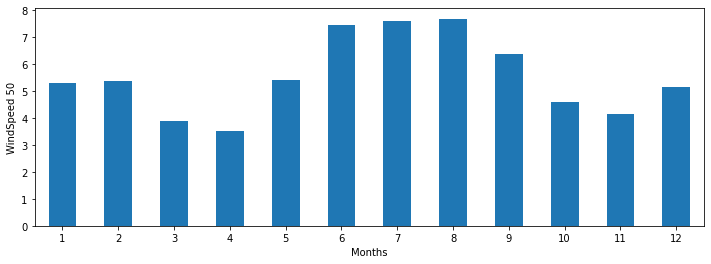

In [7]:
fig, axs = plt.subplots(figsize=(12, 4))
dataset.groupby(dataset.index.month)[
    'WindSpeed 50'].mean().plot(kind='bar', rot=0, ax=axs)
plt.xlabel("Months")
plt.ylabel(target_col)
plt.show()


In [8]:
# dataset split
TRAIN_SPLIT = int(len(dataset)*train_percent)
train_df, test_df = dataset[:TRAIN_SPLIT], dataset[TRAIN_SPLIT:]
train_df.shape, test_df.shape


((34721, 4), (17887, 4))

In [9]:
train = train_df
scalers = {}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_' + i] = scaler
    train[i] = s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1, 1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_'+i] = scaler
    test[i] = s_s
train.shape,test.shape


/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_6086/3052059877.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = s_s
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_6086/3052059877.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = s_s
/var/folders/7c/546hxb311rs7g1vpllxz9r500000gn/T/ipykernel_6086/3052059877.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

((34721, 4), (17887, 4))

In [10]:
def split_series(series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end,
                              :], series[past_end:future_end, 1]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)


In [11]:
X_train, y_train = split_series(train.values, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(34617, 100, 4) (34617, 5)
(17783, 100, 4) (17783, 5)


In [12]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#

def stackedLstm1():
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)

    encoder_states1 = encoder_outputs1[1:]

    #
    decoder_inputs = tf.keras.layers.RepeatVector(
        n_future)(encoder_outputs1[0])

    #
    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(
        decoder_inputs, initial_state=encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(1))(decoder_l1)

    #
    model_e1d1 = tf.keras.models.Model(encoder_inputs, decoder_outputs1)

    #
    model_e1d1.summary()
    return model_e1d1


In [13]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
def stackedLstm2():
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    encoder_l1 = tf.keras.layers.LSTM(
        100, return_sequences=True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #
    decoder_inputs = tf.keras.layers.RepeatVector(
        n_future)(encoder_outputs2[0])
    #
    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(
        decoder_inputs, initial_state=encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(
        decoder_l1, initial_state=encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(1))(decoder_l2)
    #
    model_e2d2 = tf.keras.models.Model(encoder_inputs, decoder_outputs2)
    #
    model_e2d2.summary()
    return model_e2d2


In [14]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 1e-3 * 0.90 ** x)

currentModel = stackedLstm1()
currentModel.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.Huber())
history_model = currentModel.fit(X_train, y_train, epochs=25, validation_data=(
    X_test, y_test), batch_size=32, verbose=1, callbacks=[reduce_lr])



Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-19 20:54:35.176486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-19 20:54:35.176589: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 4)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        42000       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 5, 100)       0           ['lstm[0][0]']                   
                                                                                              

2022-05-19 20:54:36.159792: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-19 20:54:37.343708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 20:54:37.609875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 20:54:38.811870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 20:54:40.357704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-19 20:54:41.664275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 169/1082 [===>..........................] - ETA: 24s - loss: 0.0087

KeyboardInterrupt: 

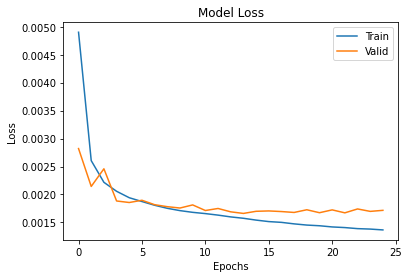

In [ ]:
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:

# currentModel = tf.keras.models.load_model("stacked_model")

pred1 = currentModel.predict(X_test)

pred = currentModel.predict(X_train)

2022-04-20 06:51:30.527533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 06:51:30.599110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 06:51:30.767832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
pred1.shape,pred.shape

((17783, 5, 1), (34617, 5, 1))

In [ ]:
# for index,_ in enumerate(train_df.columns):
scaler = scalers['scaler_WindSpeed 50']
pred1[:,:,0] = scaler.inverse_transform(pred1[:,:,0])
pred[:,:,0] = scaler.inverse_transform(pred[:,:,0])

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


In [ ]:
y_test.shape

(17783, 5)

In [ ]:
# for j in range(1, n_future+1):
#     print("Hour ", j, ":")
#     print("RMSE: ", np.sqrt(mean_squared_error(
#         y_test[:, j-1], pred1[:, j-1, 0])), end=", ")      
#     print()

index =0
print("RMSE: ", np.sqrt(mean_squared_error(
        y_train[:, index], pred[:, index, 0])), end=", \n")
print("MSE: ",mean_squared_error(
        y_train[:, index], pred[:, index, 0]), end=", \n")
print("MAE: ", mean_absolute_error(
        y_train[:, index], pred[:, index, 0]), end=", \n")       

RMSE:  0.25336793, 
MSE:  0.06419531, 
MAE:  0.1958986, 


In [ ]:
pred1[0,:,0].shape,y_test[0].shape

((5,), (5,))

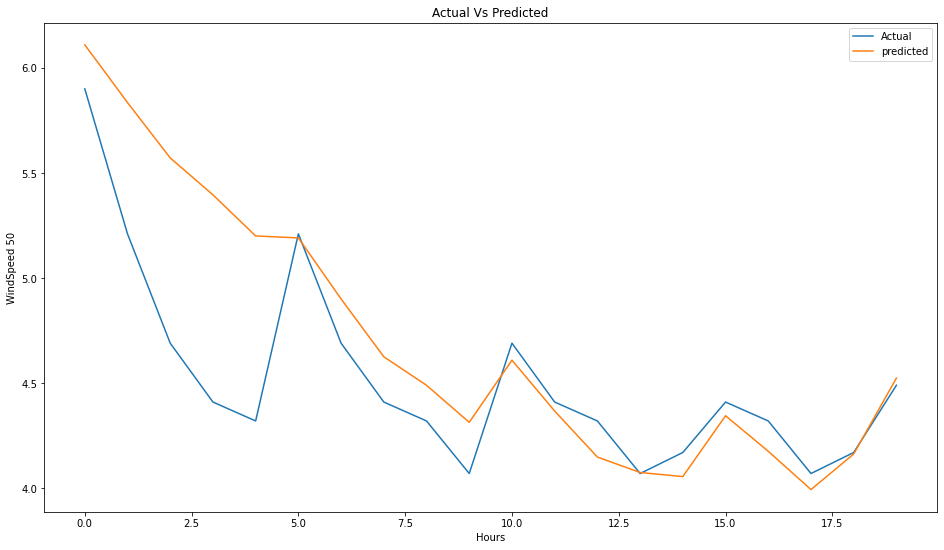

In [ ]:
index = 3

one = np.concatenate((y_train[index],y_train[index+1],y_train[index+2],y_train[index+3]))
two = np.concatenate((pred[index,:,0],pred[index+1,:,0],pred[index+2,:,0],pred[index+3,:,0]))

plt.figure(figsize=(16,9))
plt.title('Actual Vs Predicted')
plt.ylabel('WindSpeed 50')
plt.xlabel('Hours')
plt.plot(one)
plt.plot(two)
plt.legend(('Actual','predicted'))